In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.text import *

In [0]:
path = untar_data(URLs.HUMAN_NUMBERS)
path.ls()

[PosixPath('/root/.fastai/data/human_numbers/train.txt'),
 PosixPath('/root/.fastai/data/human_numbers/valid.txt'),
 PosixPath('/root/.fastai/data/human_numbers/models')]

In [0]:
def read_txt(d):
  return [','.join(t.strip() for t in open(path/d).readlines())]

In [0]:
train_txt = read_txt('train.txt')
train_txt[0][:50]

'one,two,three,four,five,six,seven,eight,nine,ten,e'

In [0]:
val_txt = read_txt('valid.txt')
val_txt[0][:50]

'eight thousand one,eight thousand two,eight thousa'

In [0]:
train = TextList(train_txt,path=path)
val = TextList(val_txt,path=path)

In [0]:
bs = 64

In [0]:
src = ItemLists(path=path,train=train,valid=val).label_for_lm()
data = src.databunch(bs=bs)

In [0]:
data.bptt,len(data.valid_dl)

(70, 3)

In [0]:
len(data.valid_ds[0][0].data)

13017

In [0]:
len(data.valid_ds[0][0].data)/64/70

2.905580357142857

In [0]:
vl = iter(data.valid_dl)
x1,y1 = next(vl)
x2,y2 = next(vl)
x3,y3 = next(vl)
vl.close()

In [0]:
x1

tensor([[ 2, 19, 11,  ..., 36,  9, 19],
        [ 9, 19, 11,  ..., 24, 20,  9],
        [11, 27, 18,  ...,  9, 19, 11],
        ...,
        [20, 11, 20,  ..., 11, 20, 10],
        [20, 11, 20,  ..., 24,  9, 20],
        [20, 10, 26,  ..., 20, 11, 20]], device='cuda:0')

In [0]:
y1

tensor([[19, 11, 12,  ...,  9, 19, 11],
        [19, 11, 23,  ..., 20,  9, 19],
        [27, 18,  9,  ..., 19, 11, 12],
        ...,
        [11, 20, 10,  ..., 20, 10, 21],
        [11, 20, 10,  ...,  9, 20, 11],
        [10, 26,  9,  ..., 11, 20, 10]], device='cuda:0')

In [0]:
x1.numel()+x2.numel()+x3.numel()

13440

In [0]:
x1.shape,y1.shape

(torch.Size([64, 70]), torch.Size([64, 70]))

In [0]:
x2.shape,y2.shape

(torch.Size([64, 70]), torch.Size([64, 70]))

In [0]:
v = data.valid_ds.vocab

In [0]:
v.textify(x1[0])

'xxbos eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight'

In [0]:
v.textify(x2[0])

'thousand eighteen , eight thousand nineteen , eight thousand twenty , eight thousand twenty one , eight thousand twenty two , eight thousand twenty three , eight thousand twenty four , eight thousand twenty five , eight thousand twenty six , eight thousand twenty seven , eight thousand twenty eight , eight thousand twenty nine , eight thousand thirty , eight thousand thirty one , eight thousand thirty two ,'

In [0]:
v.textify(x3[0])

'eight thousand thirty three , eight thousand thirty four , eight thousand thirty five , eight thousand thirty six , eight thousand thirty seven , eight thousand thirty eight , eight thousand thirty nine , eight thousand forty , eight thousand forty one , eight thousand forty two , eight thousand forty three , eight thousand forty four , eight thousand forty five , eight thousand forty six , eight'

In [0]:
data.show_batch(ds_type=DatasetType.Valid)

idx,text
0,"thousand forty seven , eight thousand forty eight , eight thousand forty nine , eight thousand fifty , eight thousand fifty one , eight thousand fifty two , eight thousand fifty three , eight thousand fifty four , eight thousand fifty five , eight thousand fifty six , eight thousand fifty seven , eight thousand fifty eight , eight thousand fifty nine , eight thousand sixty , eight thousand sixty"
1,"eight , eight thousand eighty nine , eight thousand ninety , eight thousand ninety one , eight thousand ninety two , eight thousand ninety three , eight thousand ninety four , eight thousand ninety five , eight thousand ninety six , eight thousand ninety seven , eight thousand ninety eight , eight thousand ninety nine , eight thousand one hundred , eight thousand one hundred one , eight thousand one"
2,"thousand one hundred twenty four , eight thousand one hundred twenty five , eight thousand one hundred twenty six , eight thousand one hundred twenty seven , eight thousand one hundred twenty eight , eight thousand one hundred twenty nine , eight thousand one hundred thirty , eight thousand one hundred thirty one , eight thousand one hundred thirty two , eight thousand one hundred thirty three , eight thousand"
3,"three , eight thousand one hundred fifty four , eight thousand one hundred fifty five , eight thousand one hundred fifty six , eight thousand one hundred fifty seven , eight thousand one hundred fifty eight , eight thousand one hundred fifty nine , eight thousand one hundred sixty , eight thousand one hundred sixty one , eight thousand one hundred sixty two , eight thousand one hundred sixty three"
4,"thousand one hundred eighty three , eight thousand one hundred eighty four , eight thousand one hundred eighty five , eight thousand one hundred eighty six , eight thousand one hundred eighty seven , eight thousand one hundred eighty eight , eight thousand one hundred eighty nine , eight thousand one hundred ninety , eight thousand one hundred ninety one , eight thousand one hundred ninety two , eight thousand"


In [0]:
data = src.databunch(bs=bs, bptt=3)

In [0]:
x,y = data.one_batch()
x.shape,y.shape

(torch.Size([64, 3]), torch.Size([64, 3]))

In [0]:
nh = 64

In [0]:
nv = len(v.itos)
nv

40

In [0]:
def loss4(input,target): return F.cross_entropy(input, target[:,-1])
def acc4 (input,target): return accuracy(input, target[:,-1])

In [0]:
class Model0(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)  # green arrow
        self.h_h = nn.Linear(nh,nh)     # brown arrow
        self.h_o = nn.Linear(nh,nv)     # blue arrow
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = self.bn(F.relu(self.h_h(self.i_h(x[:,0]))))
        if x.shape[1]>1:
            h = h + self.i_h(x[:,1])
            h = self.bn(F.relu(self.h_h(h)))
        if x.shape[1]>2:
            h = h + self.i_h(x[:,2])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [0]:
learn = Learner(data=data,model=Model0(),loss_func=loss4,metrics=acc4)

In [0]:
learn.fit_one_cycle(6,1e-04)

epoch,train_loss,valid_loss,acc4,time
0,3.591353,3.410332,0.142233,00:01
1,2.623211,2.588534,0.447610,00:01
2,2.063565,2.189209,0.462776,00:01
3,1.851567,2.063987,0.468520,00:01
4,1.776607,2.033115,0.455193,00:01
5,1.760999,2.029960,0.455193,00:01


In [0]:
class Model1(nn.Module):

  def __init__(self):
    super().__init__()
    self.i_h = nn.Embedding(nv,nh)
    self.h_h = nn.Linear(nh,nh)
    self.h_o = nn.Linear(nh,nv)
    self.bn = nn.BatchNorm1d(nh)
  
  def forward(self,x):
    h = torch.zeros(x.shape[0],nh).to(device = x.device)
    for i in range(x.shape[1]):
      h = h + self.i_h(x[:,i])
      h = self.bn(F.relu(self.h_h(h)))
    return self.h_o(h)

In [0]:
learn = Learner(data=data,model=Model1(),loss_func=loss4,metrics=acc4)

In [0]:
learn.fit_one_cycle(6,1e-04)

In [0]:
data = src.databunch(bs=bs,bptt = 20)
x,y = data.one_batch()
x.shape,y.shape

(torch.Size([64, 20]), torch.Size([64, 20]))

In [0]:
class Model2(nn.Module):

  def __init__(self):
    super().__init__()
    self.i_h = nn.Embedding(nv,nh)
    self.h_h = nn.Linear(nh,nh)
    self.h_o = nn.Linear(nh,nv)
    self.bn = nn.BatchNorm1d(nh)
  
  def forward(self,x):
    h = torch.zeros(x.shape[0],nh).to(device=x.device)
    res = []
    for i in range(x.shape[1]):
      h = h + self.i_h(x[:,i])
      h = F.relu(self.h_h(h))
      res.append(self.h_o(self.bn(h)))
    
    return torch.stack(res,dim=1)

In [0]:
learn = Learner(data=data,model=Model2(),metrics=accuracy)

In [0]:
learn.fit_one_cycle(10,1e-04,pct_start=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.885001,3.864966,0.026349,00:00
1,3.706705,3.674344,0.045597,00:00
2,3.488479,3.487994,0.112145,00:00
3,3.267871,3.324560,0.203480,00:00
4,3.072359,3.195693,0.286790,00:00
5,2.914793,3.102956,0.307031,00:00
6,2.797756,3.042553,0.316264,00:00
7,2.718112,3.009608,0.324503,00:00
8,2.669869,2.996953,0.332173,00:00
9,2.644836,2.995052,0.333523,00:00


In [0]:
class Model3(nn.Module):

  def __init__(self):
    super().__init__()
    self.i_h = nn.Embedding(nv,nh)
    self.h_h = nn.Linear(nh,nh)
    self.h_o = nn.Linear(nh,nv)
    self.bn = nn.BatchNorm1d(nh)
    self.h = torch.zeros(bs,nh).cuda()
  def forward(self,x):
    res = []
    h = self.h
    for i in range(x.shape[1]):
      h = h+ self.i_h(x[:,i])
      h = F.relu(self.h_h(h))
      res.append(self.bn(h))
    self.h = h.detach()
    res = torch.stack(res,dim=1)
    res = self.h_o(res)
    return res


In [0]:
learn = Learner(data=data,model=Model3(),metrics=accuracy)

In [0]:
learn.fit_one_cycle(10,1e-04,pct_start=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.743149,3.769656,0.024148,00:00
1,3.554654,3.542225,0.097088,00:00
2,3.329554,3.327884,0.205753,00:00
3,3.108986,3.146759,0.260511,00:00
4,2.914080,3.002327,0.341690,00:00
5,2.756186,2.899853,0.364489,00:00
6,2.639175,2.833347,0.370455,00:00
7,2.559968,2.797467,0.375355,00:00
8,2.512155,2.783707,0.376492,00:00
9,2.487377,2.781662,0.376349,00:00


In [0]:
class Model4(nn.Module):
  def __init__(self):
    super().__init__()
    self.i_h = nn.Embedding(nv,nh)
    self.rnn = nn.RNN(nh,nh,batch_first=True)
    self.h_o = nn.Linear(nh,nv)
    self.bn = BatchNorm1dFlat(nh)
    self.h = torch.zeros(1,bs,nh).cuda()

  def forward(self,x):
    res,h = self.rnn(self.i_h(x),self.h)
    self.h = h.detach()
    return self.h_o(self.bn(res))

In [0]:
learn = Learner(data,Model4(),metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


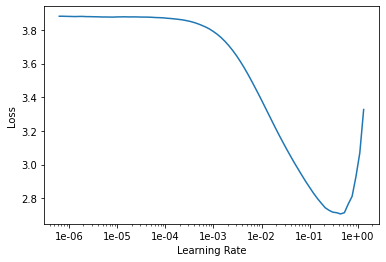

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(20,4e-03)

epoch,train_loss,valid_loss,accuracy,time
0,3.405839,3.098647,0.360582,00:00
1,2.618380,2.092501,0.465199,00:00
2,2.005428,2.053009,0.314702,00:00
3,1.704763,2.078650,0.316122,00:00
4,1.522584,1.877290,0.426491,00:00
5,1.349181,2.121670,0.464418,00:00
6,1.182967,1.793852,0.513068,00:00
7,1.037719,1.622313,0.558381,00:00
8,0.915337,1.594229,0.558807,00:00
9,0.820022,1.564547,0.586932,00:00


In [0]:
class Model5(nn.Module):
  def __init__(self):
    super().__init__()
    self.i_h = nn.Embedding(nv,nh)
    self.gru = nn.GRU(nh,nh,2,batch_first = True)
    self.h_o = nn.Linear(nh,nv)
    self.bn = BatchNorm1dFlat(nh)
    self.h = torch.zeros(2,bs,nh).cuda()

  def forward(self,x):
    res,h = self.gru(self.i_h(x),self.h)
    self.h = h.detach()
    return self.h_o(self.bn(res))

In [0]:
learn = Learner(data,Model5(),metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


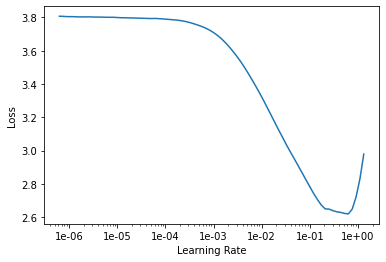

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(20,4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.317178,3.121619,0.411861,00:00
1,2.549461,2.108489,0.470597,00:00
2,1.821286,1.666186,0.632386,00:00
3,1.120842,1.057471,0.760867,00:00
4,0.617808,0.915046,0.796875,00:00
5,0.333963,0.915290,0.780398,00:00
6,0.186479,0.916430,0.790057,00:00
7,0.111503,1.000486,0.781889,00:00
8,0.072775,1.049349,0.775284,00:00
9,0.051430,1.135956,0.767116,00:00
